In [1]:
import pandas as pd
from openprompt.data_utils import InputExample
classes = [ # There are two classes in Sentiment Analysis, one for negative and one for positive
    "negative",
    "positive"
]
dataset = [ # For simplicity, there's only two examples
    # text_a is the input text of the data, some other datasets may have multiple input sentences in one example.
    InputExample(
        guid = 0,
        text_a = "Albert Einstein was one of the greatest intellects of his time.",
    ),
    InputExample(
        guid = 1,
        text_a = "The film was badly made.",
    ),
]

In [2]:
from openprompt.plms import load_plm
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from openprompt.prompts import ManualTemplate
promptTemplate = ManualTemplate(
    text = '{"placeholder":"text_a"} It was {"mask"}',
    tokenizer = tokenizer,
)

In [4]:
from openprompt.prompts import ManualVerbalizer
promptVerbalizer = ManualVerbalizer(
    classes = classes,
    label_words = {
        "negative": ["bad"],
        "positive": ["good", "wonderful", "great"],
    },
    tokenizer = tokenizer,
)

In [5]:
from openprompt import PromptForClassification
promptModel = PromptForClassification(
    template = promptTemplate,
    plm = plm,
    verbalizer = promptVerbalizer,
)

In [6]:
from openprompt import PromptDataLoader
data_loader = PromptDataLoader(
    dataset = dataset,
    tokenizer = tokenizer,
    template = promptTemplate,
    tokenizer_wrapper_class=WrapperClass,
)

tokenizing: 2it [00:00, ?it/s]


In [7]:
import torch
# making zero-shot inference using pretrained MLM with prompt
promptModel.eval()
with torch.no_grad():
    for batch in data_loader:
        logits = promptModel(batch)
        preds = torch.argmax(logits, dim = -1)
        print(classes[preds])
# predictions would be 1, 0 for classes 'positive', 'negative'

positive
negative


In [8]:
from datasets import load_dataset
from openprompt.data_utils import InputExample
from transformers import  AdamW, get_linear_schedule_with_warmup
from openprompt.prompts import MixedTemplate
from openprompt import PromptDataLoader
from openprompt import PromptForClassification
from openprompt.prompts import ManualVerbalizer
import torch
from pprint import pprint
raw_dataset = load_dataset('super_glue', 'cb')
dataset = {}
for split in ['train', 'validation', 'test']:
    dataset[split] = []
    for data in raw_dataset[split]:
        input_example = InputExample(text_a = data['premise'], text_b = data['hypothesis'], label=int(data['label']), guid=data['idx'])
        dataset[split].append(input_example)
print(dataset['train'][0])

Found cached dataset super_glue (C:/Users/cq906/.cache/huggingface/datasets/super_glue/cb/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

{
  "guid": 0,
  "label": 0,
  "meta": {},
  "text_a": "It was a complex language. Not written down but handed down. One might say it was peeled down.",
  "text_b": "the language was peeled down",
  "tgt_text": null
}



In [9]:
plm, tokenizer, model_config, WrapperClass = load_plm("t5", "t5-base")
mytemplate1 = MixedTemplate(model=plm, tokenizer=tokenizer, text='{"placeholder":"text_a"} {"soft": "Question:"} {"placeholder":"text_b"}? Is it correct? {"mask"}.')
mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer, text='{"placeholder":"text_a"} {"soft"} {"soft"} {"soft"} {"placeholder":"text_b"} {"soft"} {"mask"}.')
wrapped_example = mytemplate.wrap_one_example(dataset['train'][0])
pprint(wrapped_example)

[[{'loss_ids': 0,
   'shortenable_ids': 1,
   'soft_token_ids': 0,
   'text': 'It was a complex language. Not written down but handed down. One '
           'might say it was peeled down.'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 1, 'text': ''},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 2, 'text': ''},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 3, 'text': ''},
  {'loss_ids': 0,
   'shortenable_ids': 1,
   'soft_token_ids': 0,
   'text': ' the language was peeled down'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 4, 'text': ''},
  {'loss_ids': 1, 'shortenable_ids': 0, 'soft_token_ids': 0, 'text': '<mask>'},
  {'loss_ids': 0, 'shortenable_ids': 0, 'soft_token_ids': 0, 'text': '.'}],
 {'guid': 0, 'label': 0}]


C:\Users\cq906\File\Anaconda\anaconda3\envs\NLP\lib\site-packages\transformers\models\t5\tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [10]:
wrapped_t5tokenizer=WrapperClass(max_seq_length=128,decoder_max_length=3,tokenizer=tokenizer,truncate_method='head')
train_dataloader = PromptDataLoader(dataset=dataset["train"], template=mytemplate1, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=8,shuffle=True, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")
validation_dataloader = PromptDataLoader(dataset=dataset["validation"], template=mytemplate1, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=8,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")

tokenizing: 250it [00:00, 1106.53it/s]
tokenizing: 56it [00:00, 1182.11it/s]


In [11]:
#define verbalizer : mapping from logits on the vocabulary to the final label probability
myverbalizer = ManualVerbalizer(tokenizer, num_classes=3,
                        label_words=[["yes"], ["no"], ["maybe"]])
print(myverbalizer.label_words_ids)
logits = torch.randn(2,len(tokenizer)) # creating a pseudo output from the plm
print('Vocab length:',len(tokenizer))
print('For each kind of possibility:')
myverbalizer.process_logits(logits)

Parameter containing:
tensor([[[4273]],

        [[ 150]],

        [[2087]]])
Vocab length: 32100
For each kind of possibility:


tensor([[-1.2468, -1.2651, -0.8431],
        [-0.1947, -2.0512, -3.0297]])

In [12]:
use_cuda = True
prompt_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer, freeze_plm=False)
if use_cuda:
    prompt_model=  prompt_model.cuda()

In [13]:
loss_func=torch.nn.CrossEntropyLoss()
no_decay=['bias', 'LayerNorm.weight']
# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# Using different optimizer for prompt parameters and model parameters
optimizer_grouped_parameters2 = [
    {'params': [p for n,p in prompt_model.template.named_parameters() if "raw_embedding" not in n]}
]

In [14]:
for n,p in prompt_model.named_parameters():
    print(n)
optimizer1 = AdamW(optimizer_grouped_parameters1, lr=1e-4)
optimizer2 = AdamW(optimizer_grouped_parameters2, lr=1e-3)

prompt_model.plm.shared.weight
prompt_model.plm.encoder.block.0.layer.0.SelfAttention.q.weight
prompt_model.plm.encoder.block.0.layer.0.SelfAttention.k.weight
prompt_model.plm.encoder.block.0.layer.0.SelfAttention.v.weight
prompt_model.plm.encoder.block.0.layer.0.SelfAttention.o.weight
prompt_model.plm.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight
prompt_model.plm.encoder.block.0.layer.0.layer_norm.weight
prompt_model.plm.encoder.block.0.layer.1.DenseReluDense.wi.weight
prompt_model.plm.encoder.block.0.layer.1.DenseReluDense.wo.weight
prompt_model.plm.encoder.block.0.layer.1.layer_norm.weight
prompt_model.plm.encoder.block.1.layer.0.SelfAttention.q.weight
prompt_model.plm.encoder.block.1.layer.0.SelfAttention.k.weight
prompt_model.plm.encoder.block.1.layer.0.SelfAttention.v.weight
prompt_model.plm.encoder.block.1.layer.0.SelfAttention.o.weight
prompt_model.plm.encoder.block.1.layer.0.layer_norm.weight
prompt_model.plm.encoder.block.1.layer.1.DenseReluDense.wi.wei

C:\Users\cq906\File\Anaconda\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from tqdm import tqdm
loss_list=[]
for epoch in range(10):
    tot_loss = 0
    for step, inputs in enumerate(tqdm(train_dataloader)):
        if use_cuda:
            inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        tot_loss += loss.item()
        optimizer1.step()
        optimizer1.zero_grad()
        optimizer2.step()
        optimizer2.zero_grad()
        loss_list.append(loss.item())
    tot_loss=tot_loss/len(train_dataloader)
    print('Training Loss: {:.6f}'.format(tot_loss))

100%|██████████| 32/32 [00:10<00:00,  2.92it/s]


Training Loss: 0.516750


100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Training Loss: 0.084385


100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Training Loss: 0.022404


100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


Training Loss: 0.002155


100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Training Loss: 0.001074


100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Training Loss: 0.000452


100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Training Loss: 0.000317


100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Training Loss: 0.000230


100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Training Loss: 0.000175


100%|██████████| 32/32 [00:10<00:00,  3.12it/s]

Training Loss: 0.000140


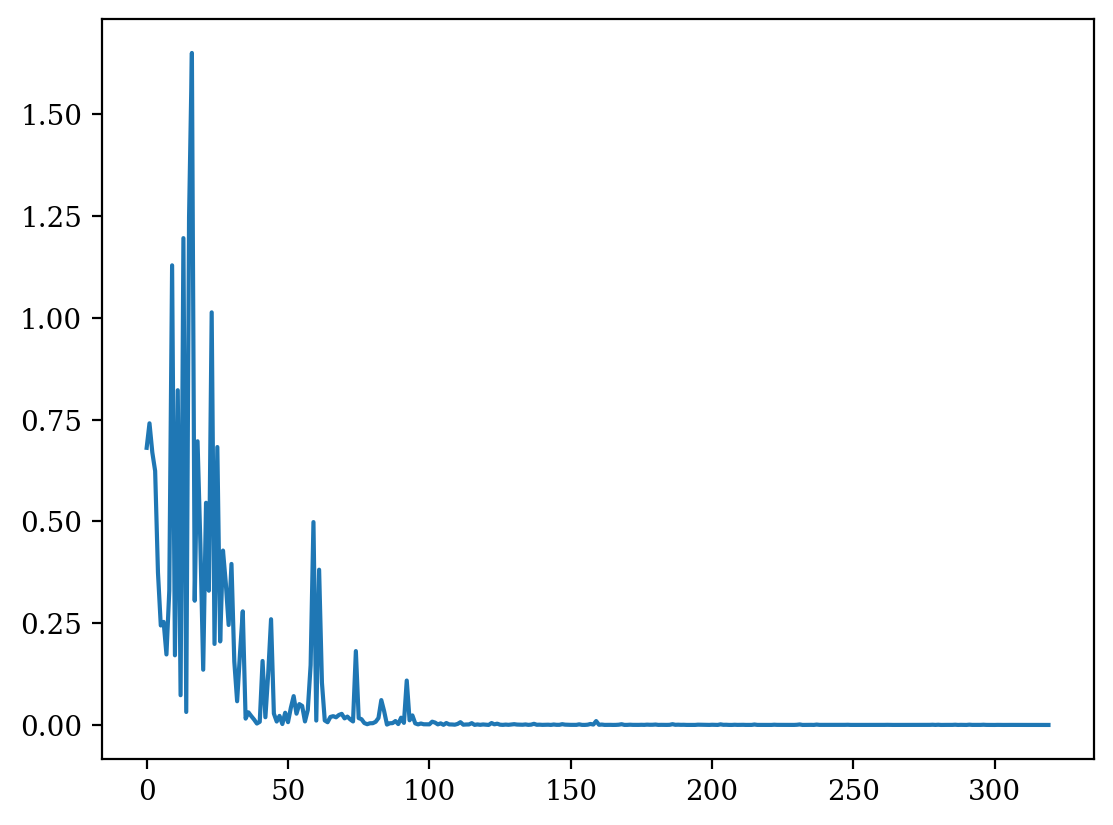

In [16]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.rcParams['font.family']='serif'
plt.plot(range(len(loss_list)),loss_list)

In [17]:
allpreds = []
alllabels = []
for step, inputs in enumerate(tqdm(validation_dataloader)):
    if use_cuda:
        inputs = inputs.cuda()
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

100%|██████████| 7/7 [00:00<00:00, 11.05it/s]


In [18]:
acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
print(acc)

0.8214285714285714
